### Model to differenciate between muons, electrons, alphas and noise

Labels: 0 noise, 1 electron, 2 muon, 3 alpha
* [Creating training and validation generators](#Creating-training-and-validation-generators)
* [Model 1: 1002 neurons, dropouts, callbacks](#Model-1:-1002-neurons,-dropouts,-callbacks)
* [Model 2: 72 neurons, dropouts](#Model-2:-72-neurons,-dropouts)
* [Model 3: 82 neurons, dropouts](#Model-3:-82-neurons,-dropouts)
* [Model 4: 82 neurons, dropouts, more filters](#Model-4:-82-neurons,-dropouts,-more-filters)
* [Model 5: 92 neurons, dropouts (best model)](#Model-5:-92-neurons,-dropouts-(best-model))

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize= 16)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize= 16)

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45, fontsize=18)
        plt.yticks(tick_marks, target_names, fontsize=18)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j], fontsize=18),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black", fontsize=18)
        else:
            plt.text(j, i, "{:,}".format(cm[i, j], fontsize=18),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black", fontsize=18)
    plt.grid(b=False)
    plt.xlim(-0.5, 3.5)
    plt.ylim(3.5, -0.5)
    plt.tight_layout()
    plt.ylabel('True label', fontsize=18)
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass), fontsize=14)
    plt.show()

In [2]:
import keras
from keras import layers, models, optimizers
from keras import callbacks

Using TensorFlow backend.


In [3]:
window_y, window_x = 242, 192 #shape of each image

In [4]:
import glob
import os, shutil
from sklearn.metrics import classification_report

### Creating training and validation generators
We need to create a numpy array (X) with the path to each npz file. Each npz contains 64 npy (batch_size), so basically, one npz is one batch. 
* For the training batchs:

In [5]:
path_tr = 'eVSmuVSaVSn_Train/'
files_tr = os.listdir(path_tr)

X = np.empty(shape=(len(files_tr),), dtype=object)

for index, file in enumerate(files_tr):     
    X[index] = os.path.join(path_tr, files_tr[index]) 

In [6]:
X.shape #we have 225 batchs (npz files) for the training

(225,)

In [7]:
def data_generator2(inputs, shuffle=True):
     while True:
    # Create list of indices
        idxs = np.arange(len(inputs))
        if shuffle:
            np.random.shuffle(idxs)

        for i in idxs:
            batch_X = []

            data = np.load(inputs[i])['X']
            label = np.load(inputs[i])['y']
 
            batch_X.append(data)


            batch_X = np.array(batch_X)
            batch_X = batch_X.reshape((batch_X.shape[1],batch_X.shape[2], batch_X.shape[3], batch_X.shape[4]))
            batch_y = label

            yield batch_X, batch_y

In [8]:
train_gen =  data_generator2(inputs=X) #training data generator

In [9]:
type(train_gen)

generator

* Similary for the validation data:

In [10]:
path_v = 'eVSmuVSaVSn_Val/'
files_v = os.listdir(path_v)

#X is a numpy array of the baths to the npz files, where each one contains a batch of npy
X = np.empty(shape=(len(files_v),), dtype=object)

for index, file in enumerate(files_v):     
    X[index] = os.path.join(path_v, files_v[index]) 

In [11]:
X.shape #this is how many batches we have of validation data

(75,)

In [12]:
val_gen = data_generator2(inputs=X)

### Model 1: 1002 neurons, dropouts, callbacks

In [13]:
model_v1 = models.Sequential()
model_v1.add(layers.Conv2D(32,(3,3), activation='relu', input_shape=(window_y, window_x, 1)))
model_v1.add(layers.MaxPooling2D((2,2)))
model_v1.add(layers.Conv2D(32,(3,3), activation='relu'))
model_v1.add(layers.MaxPooling2D((2,2)))
model_v1.add(layers.Conv2D(64,(3,3), activation='relu'))
model_v1.add(layers.MaxPooling2D((2,2)))
model_v1.add(layers.Conv2D(64,(3,3), activation='relu'))
model_v1.add(layers.MaxPooling2D((2,2)))
model_v1.add(layers.Conv2D(128,(3,3), activation='relu'))
model_v1.add(layers.MaxPooling2D((2,2)))

model_v1.add(layers.Flatten())
model_v1.add(layers.Dropout((0.5)))
model_v1.add(layers.Dense(units= 1002, activation='relu'))
model_v1.add(layers.Dropout((0.25)))
model_v1.add(layers.Dense(units= 4, activation='softmax'))
model_v1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 240, 190, 32)      320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 120, 95, 32)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 118, 93, 32)       9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 59, 46, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 57, 44, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 28, 22, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 26, 20, 64)       

In [14]:
model_v1.compile(optimizer=optimizers.RMSprop(lr= 1e-4),loss='categorical_crossentropy', metrics=['acc'])

In [15]:
my_callbacks = [
    callbacks.EarlyStopping(patience=7)
]

In [16]:
historyv1 = model_v1.fit_generator(train_gen, epochs=40, validation_data=val_gen, 
                                   steps_per_epoch= 225, validation_steps= 75, callbacks = my_callbacks)

Epoch 1/40
225/225 [==============================] - 328s 1s/step - loss: 1.0958 - acc: 0.5447 - val_loss: 0.9291 - val_acc: 0.5738
Epoch 2/40
225/225 [==============================] - 300s 1s/step - loss: 0.8965 - acc: 0.6467 - val_loss: 0.8426 - val_acc: 0.6775
Epoch 3/40
225/225 [==============================] - 301s 1s/step - loss: 0.7013 - acc: 0.6988 - val_loss: 0.4542 - val_acc: 0.7102
Epoch 4/40
225/225 [==============================] - 304s 1s/step - loss: 0.6382 - acc: 0.7319 - val_loss: 0.7567 - val_acc: 0.7300
Epoch 5/40
225/225 [==============================] - 305s 1s/step - loss: 0.5738 - acc: 0.7594 - val_loss: 0.6379 - val_acc: 0.7319
Epoch 6/40
225/225 [==============================] - 305s 1s/step - loss: 0.5109 - acc: 0.7801 - val_loss: 0.4918 - val_acc: 0.7731
Epoch 7/40
225/225 [==============================] - 318s 1s/step - loss: 0.4674 - acc: 0.7933 - val_loss: 1.1209 - val_acc: 0.7371
Epoch 8/40
225/225 [==============================] - 323s 1s/step - 

In [17]:
model_v1.save('models/e_mu_a_n_v1.h5')

* Creating the testing data from the data generator:

In [18]:
path_t = 'eVSmuVSaVSn_Test/'
files_t = os.listdir(path_t)

X = np.empty(shape=(len(files_t),), dtype=object)

for index, file in enumerate(files_t):     
    X[index] = os.path.join(path_t, files_t[index]) 

In [19]:
X.shape

(76,)

In [20]:
test_gen = data_generator2(inputs=X)

Now we can evaluate model to get the accuracy in the test date:

In [21]:
loss, acc = model_v1.evaluate_generator(test_gen, steps=76)
print('Accuracy with the model: {:5.2f}%'.format(100*acc))

Accuracy with the model: 78.97%


Finally we predict, to draw the confusion matrix:

In [22]:
def test_generator(inputs, shuffle=True):
    while True:
    # Create list of indices
        idxs = np.arange(len(inputs))
        if shuffle:
            np.random.shuffle(idxs)
        
        list_labels = []
        
        for i in idxs:
            batch_X = []

            data = np.load(inputs[i])['X']
            label = np.load(inputs[i])['y']
            batch_X.append(data)


            batch_X = np.array(batch_X)
            batch_X = batch_X.reshape((batch_X.shape[1],batch_X.shape[2], batch_X.shape[3], batch_X.shape[4]))
            batch_y = label
            list_labels.append(batch_y)
            
            yield batch_X, batch_y
            
        list_labels = np.array(list_labels)
        list_labels.flatten()
        np.save('y_labels' , list_labels)

In [23]:
def gen_true_y():
    true_labels = np.load('y_labels.npy')
    true_labels = true_labels.reshape(true_labels.shape[0]*true_labels.shape[1],4)
    true_labels = np.argmax(true_labels, axis=1)
    
    return true_labels

In [24]:
y_predicted1 = model_v1.predict_generator(test_generator(X), steps=76)

In [25]:
y_predicted1[0:10]

array([[9.9707603e-01, 8.5757015e-04, 4.5588383e-04, 1.6106223e-03],
       [9.9707663e-01, 8.5730694e-04, 4.5555487e-04, 1.6103975e-03],
       [8.9850073e-05, 4.8633981e-01, 4.4104981e-01, 7.2520487e-02],
       [1.2844109e-08, 4.3886271e-01, 5.2811354e-01, 3.3023745e-02],
       [1.6857155e-15, 7.0250976e-01, 2.9748008e-01, 1.0168296e-05],
       [9.9275127e-08, 4.2428085e-01, 3.7079754e-01, 2.0492150e-01],
       [3.8506278e-13, 7.3659825e-01, 2.6335928e-01, 4.2497562e-05],
       [0.0000000e+00, 7.9308631e-09, 3.5358049e-12, 1.0000000e+00],
       [4.4770054e-08, 3.5840565e-01, 6.0324937e-01, 3.8345009e-02],
       [9.9708134e-01, 8.5578795e-04, 4.5488041e-04, 1.6079650e-03]],
      dtype=float32)

In [26]:
y_predicted1 = np.argmax(y_predicted1, axis=1)

In [27]:
y_predicted1[0:10]

array([0, 0, 1, 2, 1, 1, 1, 3, 2, 0])

In [28]:
true_labels = gen_true_y()

In [29]:
true_labels[0:10]

array([0, 0, 1, 1, 2, 2, 2, 3, 2, 0])

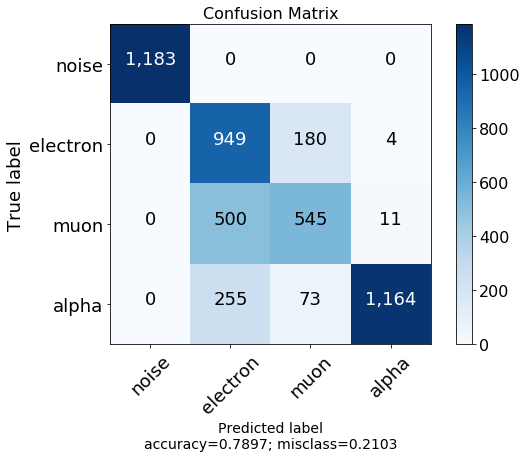

In [30]:
conf1 = confusion_matrix(true_labels, y_predicted1, labels = list([0,1,2,3]))
plot_confusion_matrix(cm           = conf1, 
                      normalize    = False,
                      target_names = ['noise','electron', 'muon','alpha'],
                      title        = "Confusion Matrix")

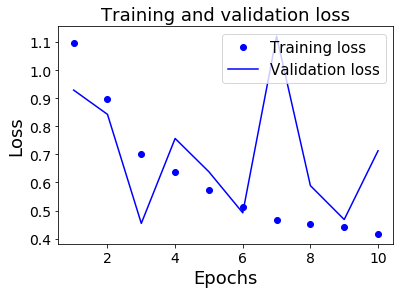

In [31]:
history_n1 = historyv1.history
loss_values_n1 = history_n1['loss']
val_loss_values_n1 = history_n1['val_loss']
epochs_n1 = range(1, len(loss_values_n1) + 1)
plt.plot(epochs_n1, loss_values_n1, 'bo', label='Training loss')
plt.plot(epochs_n1, val_loss_values_n1, 'b', label='Validation loss')
plt.title('Training and validation loss', fontsize=18)
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.legend(fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [32]:
target_names=['noise','electron', 'muon','alpha']

In [33]:
print(classification_report(true_labels, y_predicted1, target_names=target_names))

              precision    recall  f1-score   support

       noise       1.00      1.00      1.00      1183
    electron       0.56      0.84      0.67      1133
        muon       0.68      0.52      0.59      1056
       alpha       0.99      0.78      0.87      1492

    accuracy                           0.79      4864
   macro avg       0.81      0.78      0.78      4864
weighted avg       0.82      0.79      0.79      4864



### Model 2: 72 neurons, dropouts

In [34]:
model_v2 = models.Sequential()
model_v2.add(layers.Conv2D(32,(3,3), activation='relu', input_shape=(window_y, window_x, 1)))
model_v2.add(layers.MaxPooling2D((2,2)))
model_v2.add(layers.Conv2D(32,(3,3), activation='relu'))
model_v2.add(layers.MaxPooling2D((2,2)))
model_v2.add(layers.Conv2D(64,(3,3), activation='relu'))
model_v2.add(layers.MaxPooling2D((2,2)))
model_v2.add(layers.Conv2D(128,(3,3), activation='relu'))
model_v2.add(layers.MaxPooling2D((2,2)))
model_v2.add(layers.Conv2D(128,(2,2), activation='relu'))
model_v2.add(layers.MaxPooling2D((2,2)))

model_v2.add(layers.Flatten())
model_v2.add(layers.Dropout((0.5)))
model_v2.add(layers.Dense(units= 72, activation='relu'))
model_v2.add(layers.Dropout((0.25)))
model_v2.add(layers.Dense(units= 4, activation='softmax'))
model_v2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 240, 190, 32)      320       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 120, 95, 32)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 118, 93, 32)       9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 59, 46, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 57, 44, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 28, 22, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 26, 20, 128)      

In [35]:
model_v2.compile(optimizer=optimizers.RMSprop(lr= 1e-4),loss='categorical_crossentropy', metrics=['acc'])

In [36]:
historyv2 = model_v2.fit_generator(train_gen, epochs=40, validation_data=val_gen, 
                                   steps_per_epoch= 225, validation_steps= 75, callbacks=my_callbacks)

Epoch 1/40
225/225 [==============================] - 337s 1s/step - loss: 1.1700 - acc: 0.4995 - val_loss: 1.0453 - val_acc: 0.5310
Epoch 2/40
225/225 [==============================] - 344s 2s/step - loss: 0.9375 - acc: 0.5983 - val_loss: 0.9051 - val_acc: 0.6419
Epoch 3/40
225/225 [==============================] - 338s 2s/step - loss: 0.8066 - acc: 0.6515 - val_loss: 1.1887 - val_acc: 0.6846
Epoch 4/40
225/225 [==============================] - 343s 2s/step - loss: 0.7468 - acc: 0.6726 - val_loss: 0.5097 - val_acc: 0.6992
Epoch 5/40
225/225 [==============================] - 342s 2s/step - loss: 0.7133 - acc: 0.6824 - val_loss: 0.7121 - val_acc: 0.7013
Epoch 6/40
225/225 [==============================] - 341s 2s/step - loss: 0.6692 - acc: 0.6976 - val_loss: 0.4575 - val_acc: 0.7244
Epoch 7/40
225/225 [==============================] - 345s 2s/step - loss: 0.6357 - acc: 0.7110 - val_loss: 0.7249 - val_acc: 0.7073
Epoch 8/40
225/225 [==============================] - 339s 2s/step - 

In [37]:
model_v2.save('models/e_mu_a_n_v2.h5')

In [38]:
loss, acc = model_v2.evaluate_generator(test_gen, steps=76)
print('Accuracy with the model: {:5.2f}%'.format(100*acc))

Accuracy with the model: 80.14%


In [39]:
y_predicted2 = model_v2.predict_generator(test_generator(X), steps=76)

y_predicted2 = np.argmax(y_predicted2, axis=1)

true_labels = gen_true_y()

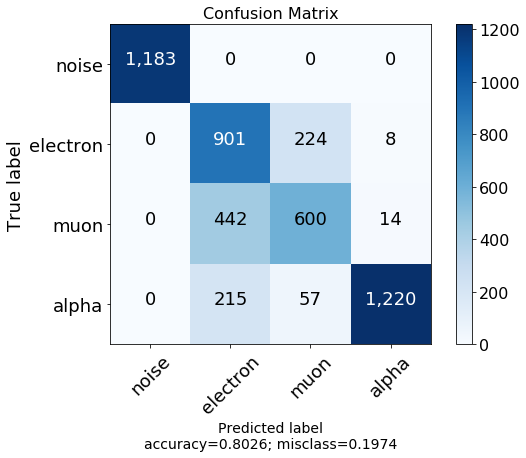

In [40]:
conf2 = confusion_matrix(true_labels, y_predicted2, labels = list([0,1,2,3]))
plot_confusion_matrix(cm           = conf2, 
                      normalize    = False,
                      target_names = target_names,
                      title        = "Confusion Matrix")

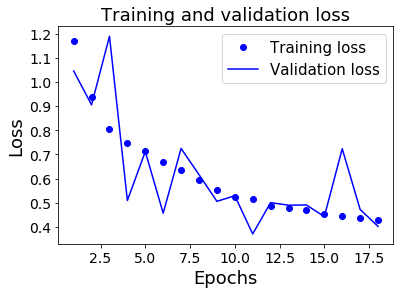

In [41]:
history_n1 = historyv2.history
loss_values_n1 = history_n1['loss']
val_loss_values_n1 = history_n1['val_loss']
epochs_n1 = range(1, len(loss_values_n1) + 1)
plt.plot(epochs_n1, loss_values_n1, 'bo', label='Training loss')
plt.plot(epochs_n1, val_loss_values_n1, 'b', label='Validation loss')
plt.title('Training and validation loss', fontsize=18)
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.legend(fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [42]:
print(classification_report(true_labels, y_predicted2, target_names=target_names))

              precision    recall  f1-score   support

       noise       1.00      1.00      1.00      1183
    electron       0.58      0.80      0.67      1133
        muon       0.68      0.57      0.62      1056
       alpha       0.98      0.82      0.89      1492

    accuracy                           0.80      4864
   macro avg       0.81      0.80      0.80      4864
weighted avg       0.83      0.80      0.81      4864



### Model 3: 82 neurons, dropouts

In [43]:
model_v6 = models.Sequential()
model_v6.add(layers.Conv2D(32,(3,3), activation='relu', input_shape=(window_y, window_x, 1)))
model_v6.add(layers.MaxPooling2D((2,2)))
model_v6.add(layers.Conv2D(32,(3,3), activation='relu'))
model_v6.add(layers.MaxPooling2D((2,2)))
model_v6.add(layers.Conv2D(64,(3,3), activation='relu'))
model_v6.add(layers.MaxPooling2D((2,2)))
model_v6.add(layers.Conv2D(128,(2,2), activation='relu'))
model_v6.add(layers.MaxPooling2D((2,2)))

model_v6.add(layers.Flatten())
model_v6.add(layers.Dropout((0.5)))
model_v6.add(layers.Dense(units= 82, activation='relu'))
model_v6.add(layers.Dropout((0.25)))
model_v6.add(layers.Dense(units= 4, activation='softmax'))
model_v6.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 240, 190, 32)      320       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 120, 95, 32)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 118, 93, 32)       9248      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 59, 46, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 57, 44, 64)        18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 28, 22, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 27, 21, 128)      

In [44]:
model_v6.compile(optimizer=optimizers.RMSprop(lr= 1e-4),loss='categorical_crossentropy', metrics=['acc'])

In [45]:
historyv6 = model_v6.fit_generator(train_gen, epochs=40, validation_data=val_gen, 
                                   steps_per_epoch= 225, validation_steps= 75,callbacks=my_callbacks)

Epoch 1/40
225/225 [==============================] - 342s 2s/step - loss: 1.1071 - acc: 0.5396 - val_loss: 1.0828 - val_acc: 0.6042
Epoch 2/40
225/225 [==============================] - 335s 1s/step - loss: 0.8855 - acc: 0.6176 - val_loss: 0.7147 - val_acc: 0.6323
Epoch 3/40
225/225 [==============================] - 349s 2s/step - loss: 0.8056 - acc: 0.6449 - val_loss: 0.8261 - val_acc: 0.6658
Epoch 4/40
225/225 [==============================] - 374s 2s/step - loss: 0.7370 - acc: 0.6753 - val_loss: 0.6581 - val_acc: 0.6844
Epoch 5/40
225/225 [==============================] - 355s 2s/step - loss: 0.6685 - acc: 0.7062 - val_loss: 0.4908 - val_acc: 0.7115
Epoch 6/40
225/225 [==============================] - 347s 2s/step - loss: 0.5924 - acc: 0.7319 - val_loss: 0.6116 - val_acc: 0.7437
Epoch 7/40
225/225 [==============================] - 363s 2s/step - loss: 0.5376 - acc: 0.7615 - val_loss: 0.4664 - val_acc: 0.7419
Epoch 8/40
225/225 [==============================] - 344s 2s/step - 

In [46]:
model_v6.save('models/e_mu_a_n_v3.h5')

In [47]:
loss, acc = model_v6.evaluate_generator(test_gen, steps=76)
print('Accuracy with the model: {:5.2f}%'.format(100*acc))

Accuracy with the model: 80.32%


In [48]:
y_predicted6 = model_v6.predict_generator(test_generator(X), steps=76)

y_predicted6 = np.argmax(y_predicted6, axis=1)

true_labels = gen_true_y()

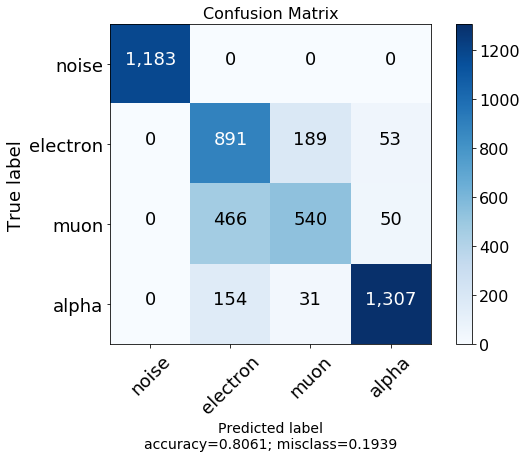

In [49]:
conf6 = confusion_matrix(true_labels, y_predicted6, labels = list([0,1,2,3]))
plot_confusion_matrix(cm           = conf6, 
                      normalize    = False,
                      target_names = ['noise','electron', 'muon','alpha'],
                      title        = "Confusion Matrix")

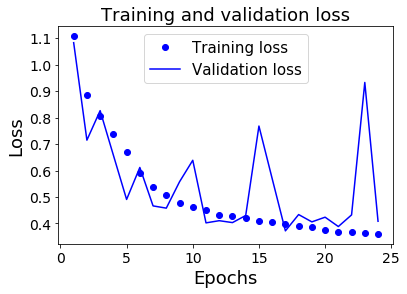

In [50]:
history_n1 = historyv6.history
loss_values_n1 = history_n1['loss']
val_loss_values_n1 = history_n1['val_loss']
epochs_n1 = range(1, len(loss_values_n1) + 1)
plt.plot(epochs_n1, loss_values_n1, 'bo', label='Training loss')
plt.plot(epochs_n1, val_loss_values_n1, 'b', label='Validation loss')
plt.title('Training and validation loss', fontsize=18)
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.legend(fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [51]:
print(classification_report(true_labels, y_predicted6, target_names=target_names))

              precision    recall  f1-score   support

       noise       1.00      1.00      1.00      1183
    electron       0.59      0.79      0.67      1133
        muon       0.71      0.51      0.59      1056
       alpha       0.93      0.88      0.90      1492

    accuracy                           0.81      4864
   macro avg       0.81      0.79      0.79      4864
weighted avg       0.82      0.81      0.81      4864



### Model 4: 82 neurons, dropouts, more filters

In [52]:
model_v7 = models.Sequential()
model_v7.add(layers.Conv2D(32,(3,3), activation='relu', input_shape=(window_y, window_x, 1)))
model_v7.add(layers.MaxPooling2D((2,2)))
model_v7.add(layers.Conv2D(32,(3,3), activation='relu'))
model_v7.add(layers.MaxPooling2D((2,2)))
model_v7.add(layers.Conv2D(64,(3,3), activation='relu'))
model_v7.add(layers.MaxPooling2D((2,2)))
model_v7.add(layers.Conv2D(128,(3,3), activation='relu'))
model_v7.add(layers.MaxPooling2D((2,2)))
model_v7.add(layers.Conv2D(128,(2,2), activation='relu'))
model_v7.add(layers.MaxPooling2D((2,2)))

model_v7.add(layers.Flatten())
model_v7.add(layers.Dropout((0.5)))
model_v7.add(layers.Dense(units= 82, activation='relu'))
model_v7.add(layers.Dropout((0.25)))
model_v7.add(layers.Dense(units= 4, activation='softmax'))
model_v7.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 240, 190, 32)      320       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 120, 95, 32)       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 118, 93, 32)       9248      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 59, 46, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 57, 44, 64)        18496     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 28, 22, 64)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 26, 20, 128)      

In [53]:
model_v7.compile(optimizer=optimizers.RMSprop(learning_rate=1e-4),loss='categorical_crossentropy', metrics=['acc'])

In [54]:
historyv7 = model_v7.fit_generator(train_gen, epochs=40, validation_data=val_gen, 
                                   steps_per_epoch= 225, validation_steps= 75,callbacks=my_callbacks)

Epoch 1/40
225/225 [==============================] - 326s 1s/step - loss: 1.2069 - acc: 0.4310 - val_loss: 1.0868 - val_acc: 0.5600
Epoch 2/40
225/225 [==============================] - 321s 1s/step - loss: 0.9530 - acc: 0.5901 - val_loss: 0.6860 - val_acc: 0.6569
Epoch 3/40
225/225 [==============================] - 343s 2s/step - loss: 0.8162 - acc: 0.6527 - val_loss: 0.6927 - val_acc: 0.6737
Epoch 4/40
225/225 [==============================] - 323s 1s/step - loss: 0.7524 - acc: 0.6724 - val_loss: 0.7935 - val_acc: 0.6794
Epoch 5/40
225/225 [==============================] - 321s 1s/step - loss: 0.7167 - acc: 0.6853 - val_loss: 0.8132 - val_acc: 0.6917
Epoch 6/40
225/225 [==============================] - 322s 1s/step - loss: 0.6687 - acc: 0.7024 - val_loss: 0.7373 - val_acc: 0.7033
Epoch 7/40
225/225 [==============================] - 322s 1s/step - loss: 0.6326 - acc: 0.7163 - val_loss: 0.5869 - val_acc: 0.7337
Epoch 8/40
225/225 [==============================] - 331s 1s/step - 

In [55]:
model_v7.save('models/e_mu_a_n_v4.h5')

In [56]:
loss, acc = model_v7.evaluate_generator(test_gen, steps=76)
print('Accuracy with the model: {:5.2f}%'.format(100*acc))

Accuracy with the model: 79.77%


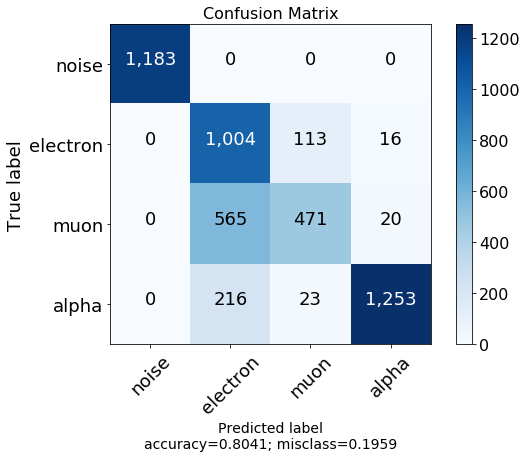

In [57]:
y_predicted7 = model_v7.predict_generator(test_generator(X), steps=76)

y_predicted7 = np.argmax(y_predicted7, axis=1)

true_labels = gen_true_y()

conf7 = confusion_matrix(true_labels, y_predicted7, labels = list([0,1,2,3]))
plot_confusion_matrix(cm           = conf7, 
                      normalize    = False,
                      target_names = target_names,
                      title        = "Confusion Matrix")

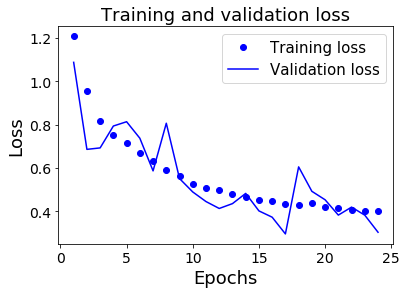

In [58]:
history_n1 = historyv7.history
loss_values_n1 = history_n1['loss']
val_loss_values_n1 = history_n1['val_loss']
epochs_n1 = range(1, len(loss_values_n1) + 1)
plt.plot(epochs_n1, loss_values_n1, 'bo', label='Training loss')
plt.plot(epochs_n1, val_loss_values_n1, 'b', label='Validation loss')
plt.title('Training and validation loss', fontsize=18)
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.legend(fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [59]:
print(classification_report(true_labels, y_predicted7, target_names=target_names))

              precision    recall  f1-score   support

       noise       1.00      1.00      1.00      1183
    electron       0.56      0.89      0.69      1133
        muon       0.78      0.45      0.57      1056
       alpha       0.97      0.84      0.90      1492

    accuracy                           0.80      4864
   macro avg       0.83      0.79      0.79      4864
weighted avg       0.84      0.80      0.80      4864



### Model 5: 92 neurons, dropouts (best model)

In [19]:
model_v9 = models.Sequential()
model_v9.add(layers.Conv2D(32,(3,3), activation='relu', input_shape=(window_y, window_x, 1)))
model_v9.add(layers.MaxPooling2D((2,2)))
model_v9.add(layers.Conv2D(32,(3,3), activation='relu'))
model_v9.add(layers.MaxPooling2D((2,2)))
model_v9.add(layers.Conv2D(64,(3,3), activation='relu'))
model_v9.add(layers.MaxPooling2D((2,2)))
model_v9.add(layers.Conv2D(64,(3,3), activation='relu'))
model_v9.add(layers.MaxPooling2D((2,2)))
model_v9.add(layers.Conv2D(128,(2,2), activation='relu'))
model_v9.add(layers.MaxPooling2D((2,2)))

model_v9.add(layers.Flatten())
model_v9.add(layers.Dropout((0.5)))
model_v9.add(layers.Dense(units= 92, activation='relu'))
model_v9.add(layers.Dropout((0.25)))
model_v9.add(layers.Dense(units= 4, activation='softmax'))
model_v9.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 240, 190, 32)      320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 120, 95, 32)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 118, 93, 32)       9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 59, 46, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 57, 44, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 28, 22, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 26, 20, 64)       

In [20]:
model_v9.compile(optimizer=optimizers.RMSprop(lr= 1e-4),loss='categorical_crossentropy', metrics=['acc'])

In [22]:
historyv9 = model_v9.fit_generator(train_gen, epochs=40, validation_data=val_gen, 
                                   steps_per_epoch= 225, validation_steps= 75,callbacks=my_callbacks)

Epoch 1/40
225/225 [==============================] - 325s 1s/step - loss: 1.1849 - acc: 0.5021 - val_loss: 0.9914 - val_acc: 0.5238
Epoch 2/40
225/225 [==============================] - 319s 1s/step - loss: 0.9912 - acc: 0.5844 - val_loss: 0.7668 - val_acc: 0.6410
Epoch 3/40
225/225 [==============================] - 321s 1s/step - loss: 0.8200 - acc: 0.6442 - val_loss: 0.7361 - val_acc: 0.6762
Epoch 4/40
225/225 [==============================] - 329s 1s/step - loss: 0.7490 - acc: 0.6722 - val_loss: 0.5480 - val_acc: 0.6871
Epoch 5/40
225/225 [==============================] - 318s 1s/step - loss: 0.7076 - acc: 0.6849 - val_loss: 0.6954 - val_acc: 0.6998
Epoch 6/40
225/225 [==============================] - 315s 1s/step - loss: 0.6767 - acc: 0.6997 - val_loss: 0.4691 - val_acc: 0.7119
Epoch 7/40
225/225 [==============================] - 313s 1s/step - loss: 0.6359 - acc: 0.7112 - val_loss: 0.5491 - val_acc: 0.7185
Epoch 8/40
225/225 [==============================] - 314s 1s/step - 

In [25]:
model_v9.save('models/e_mu_a_n_v5.h5')

In [23]:
loss, acc = model_v9.evaluate_generator(test_gen, steps=76)
print('Accuracy with the model: {:5.2f}%'.format(100*acc))

Accuracy with the model: 80.88%


In [24]:
y_predicted9 = model_v9.predict_generator(test_generator(X), steps=76)

y_predicted9 = np.argmax(y_predicted9, axis=1)

true_labels = gen_true_y()

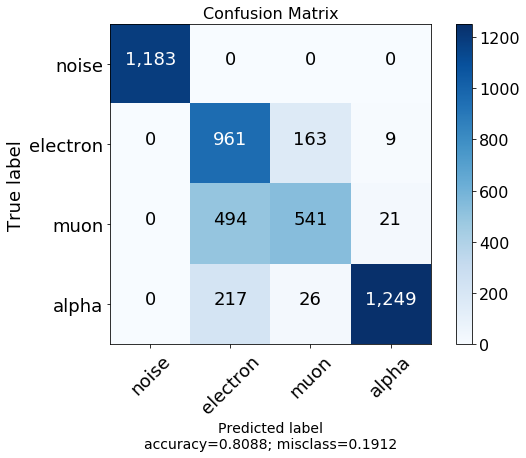

In [26]:
conf9 = confusion_matrix(true_labels, y_predicted9, labels = list([0,1,2,3]))
plot_confusion_matrix(cm           = conf9, 
                      normalize    = False,
                      target_names = target_names,
                      title        = "Confusion Matrix")

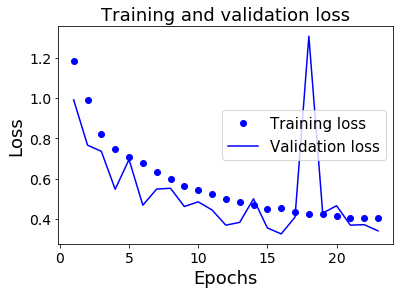

In [27]:
history_n1 = historyv9.history
loss_values_n1 = history_n1['loss']
val_loss_values_n1 = history_n1['val_loss']
epochs_n1 = range(1, len(loss_values_n1) + 1)
plt.plot(epochs_n1, loss_values_n1, 'bo', label='Training loss')
plt.plot(epochs_n1, val_loss_values_n1, 'b', label='Validation loss')
plt.title('Training and validation loss', fontsize=18)
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.legend(fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [28]:
print(classification_report(true_labels, y_predicted9, target_names=target_names))

              precision    recall  f1-score   support

       noise       1.00      1.00      1.00      1183
    electron       0.57      0.85      0.69      1133
        muon       0.74      0.51      0.61      1056
       alpha       0.98      0.84      0.90      1492

    accuracy                           0.81      4864
   macro avg       0.82      0.80      0.80      4864
weighted avg       0.84      0.81      0.81      4864

